In [1]:
# 107303538_1104_hw8_2

In [2]:
import torch
import torch.nn as nn
import numpy as np

In [3]:
t_c = [0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0] # 攝氏溫度參數
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4] # 未知參數(待得知關係的)
t_c = torch.tensor(t_c) # 轉成tensor
t_u = torch.tensor(t_u)

二次方程式模型

In [4]:
def model(t_u, w1, w2, b): # 設定模型的公式 
  return w2 * t_u**2 + w1 * t_u + b # **為次方

loss function

In [5]:
# loss為表示t_p和t_c的誤差
def loss_fn(t_p, t_c): 
  squared_diffs = (t_p - t_c)**2 
  return squared_diffs.mean() 

初始化

In [6]:
# 初始化 確定模型有在運作(可略)
w1 = torch.ones(())
w2 = torch.ones(())
b = torch.zeros(())
t_p = model(t_u, w1, w2, b)
t_p

tensor([1310.1901, 3180.7100, 3445.4399, 6789.5103, 3225.9900, 2440.1101,
        1183.1101,  497.0399, 2390.9600, 3708.5601, 4746.9600])

法1. 自訂delta求斜率 loss_rate_of_change_w1+w2

In [7]:
delta = 0.1 
# w1動 w2不動
loss_rate_of_change_w1 = (loss_fn(model(t_u, w1 + delta, w2, b), t_c) - loss_fn(model(t_u, w1 - delta, w2, b), t_c)) / (2.0 * delta)
# w2動 w1不動
loss_rate_of_change_w2 = (loss_fn(model(t_u, w1, w2 + delta, b), t_c) - loss_fn(model(t_u, w1, w2 - delta, b), t_c)) / (2.0 * delta) 

In [8]:
# 設定一學習率來修正w
learning_rate = 1e-2 
w1 = w1 - learning_rate * loss_rate_of_change_w1 
w2 = w2 - learning_rate * loss_rate_of_change_w2

In [9]:
# 用相同的方法修正b(可略)
loss_rate_of_change_b = (loss_fn(model(t_u, w1, w2, b + delta), t_c) - loss_fn(model(t_u, w1, w2, b - delta), t_c)) / (2.0 * delta)
b = b - learning_rate * loss_rate_of_change_b 

法2. 利用微小距離微分(以loss對w和b微分)求斜率

In [10]:
# 法2. 利用微小距離微分(取代delta)求斜率
def dloss_fn(t_p, t_c): # 求微分loss(斜率) 
  dsq_diffs = 2 * (t_p - t_c)  # 把loss_fn對(t_p - t_c)作微分
  return dsq_diffs

In [11]:
def dmodel_dw1(t_u, w1, w2, b): # w2 * t_u**2 + w1 * t_u + b對w1作微分
  return t_u

In [12]:
def dmodel_dw2(t_u, w1, w2, b): # 對w2作微分
  return t_u**2

In [13]:
def dmodel_db(t_u, w1, w2, b): # 對b作微分
  return 1.0

grad_fn (從chain rule) 

In [14]:
# 求出斜率(以微分方式) chain rule 
def grad_fn(t_u, t_c, t_p, w1, w2, b):
  dloss_dtp = dloss_fn(t_p, t_c) 
  dloss_dw1 = dloss_dtp * dmodel_dw1(t_u, w1, w2, b) # dloss/dtp * dmodel/dw = dloss/dw 
  dloss_dw2 = dloss_dtp * dmodel_dw2(t_u, w1, w2, b)
  dloss_db = dloss_dtp * dmodel_db(t_u, w1, w2, b) 
  # stack為combine兩個tensor
  return torch.stack([dloss_dw1.mean(), dloss_dw2.mean(), dloss_db.mean()]) # 輸出w1 w2 b

training_loop

In [15]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c):  
  for epoch in range(1, n_epochs + 1): 
    w1, w2, b = params # 把w1 w2 b 包成一個參數params
    t_p = model(t_u, w1, w2, b) 
    loss = loss_fn(t_p, t_c)  
    grad = grad_fn(t_u, t_c, t_p, w1, w2, b) # 微分斜率
    params = params - learning_rate * grad # 學習率去修正grad斜率
    print('Epoch %d, Loss %f' % (epoch, float(loss))) 
  return params # 回傳w b

t_u縮小去學

In [16]:
# 把t_u縮小成0.1去學
t_un = 0.1 * t_u

訓練開始(最後回傳w b)

In [17]:
# 嘗試用100次跌代訓練
training_loop(
  n_epochs = 100,
  learning_rate = 1e-4, # 改成1e-4 (try & error)
  params = torch.tensor([1.0, 1.0, 0.0]), # w1 w2 都設定成1.0
  t_u = t_un, 
  t_c = t_c)

Epoch 1, Loss 675.794373
Epoch 2, Loss 401.575378
Epoch 3, Loss 240.907486
Epoch 4, Loss 146.769318
Epoch 5, Loss 91.610870
Epoch 6, Loss 59.290676
Epoch 7, Loss 40.351440
Epoch 8, Loss 29.252117
Epoch 9, Loss 22.746199
Epoch 10, Loss 18.931562
Epoch 11, Loss 16.693750
Epoch 12, Loss 15.379801
Epoch 13, Loss 14.607146
Epoch 14, Loss 14.151641
Epoch 15, Loss 13.881954
Epoch 16, Loss 13.721139
Epoch 17, Loss 13.624115
Epoch 18, Loss 13.564465
Epoch 19, Loss 13.526719
Epoch 20, Loss 13.501812
Epoch 21, Loss 13.484420
Epoch 22, Loss 13.471436
Epoch 23, Loss 13.461040
Epoch 24, Loss 13.452155
Epoch 25, Loss 13.444164
Epoch 26, Loss 13.436697
Epoch 27, Loss 13.429541
Epoch 28, Loss 13.422563
Epoch 29, Loss 13.415694
Epoch 30, Loss 13.408894
Epoch 31, Loss 13.402134
Epoch 32, Loss 13.395401
Epoch 33, Loss 13.388680
Epoch 34, Loss 13.381973
Epoch 35, Loss 13.375274
Epoch 36, Loss 13.368586
Epoch 37, Loss 13.361901
Epoch 38, Loss 13.355221
Epoch 39, Loss 13.348544
Epoch 40, Loss 13.341876
Epoch

tensor([ 0.8103,  0.2702, -0.0515])

In [18]:
# 訓練5000筆資料
params = training_loop(
  n_epochs = 5000,
  learning_rate = 1e-4,
  params = torch.tensor([1.0, 1.0, 0.0]),
  t_u = t_un,
  t_c = t_c)
params 

Epoch 1, Loss 675.794373
Epoch 2, Loss 401.575378
Epoch 3, Loss 240.907486
Epoch 4, Loss 146.769318
Epoch 5, Loss 91.610870
Epoch 6, Loss 59.290676
Epoch 7, Loss 40.351440
Epoch 8, Loss 29.252117
Epoch 9, Loss 22.746199
Epoch 10, Loss 18.931562
Epoch 11, Loss 16.693750
Epoch 12, Loss 15.379801
Epoch 13, Loss 14.607146
Epoch 14, Loss 14.151641
Epoch 15, Loss 13.881954
Epoch 16, Loss 13.721139
Epoch 17, Loss 13.624115
Epoch 18, Loss 13.564465
Epoch 19, Loss 13.526719
Epoch 20, Loss 13.501812
Epoch 21, Loss 13.484420
Epoch 22, Loss 13.471436
Epoch 23, Loss 13.461040
Epoch 24, Loss 13.452155
Epoch 25, Loss 13.444164
Epoch 26, Loss 13.436697
Epoch 27, Loss 13.429541
Epoch 28, Loss 13.422563
Epoch 29, Loss 13.415694
Epoch 30, Loss 13.408894
Epoch 31, Loss 13.402134
Epoch 32, Loss 13.395401
Epoch 33, Loss 13.388680
Epoch 34, Loss 13.381973
Epoch 35, Loss 13.375274
Epoch 36, Loss 13.368586
Epoch 37, Loss 13.361901
Epoch 38, Loss 13.355221
Epoch 39, Loss 13.348544
Epoch 40, Loss 13.341876
Epoch

tensor([-0.8881,  0.5570, -0.8753])

畫圖

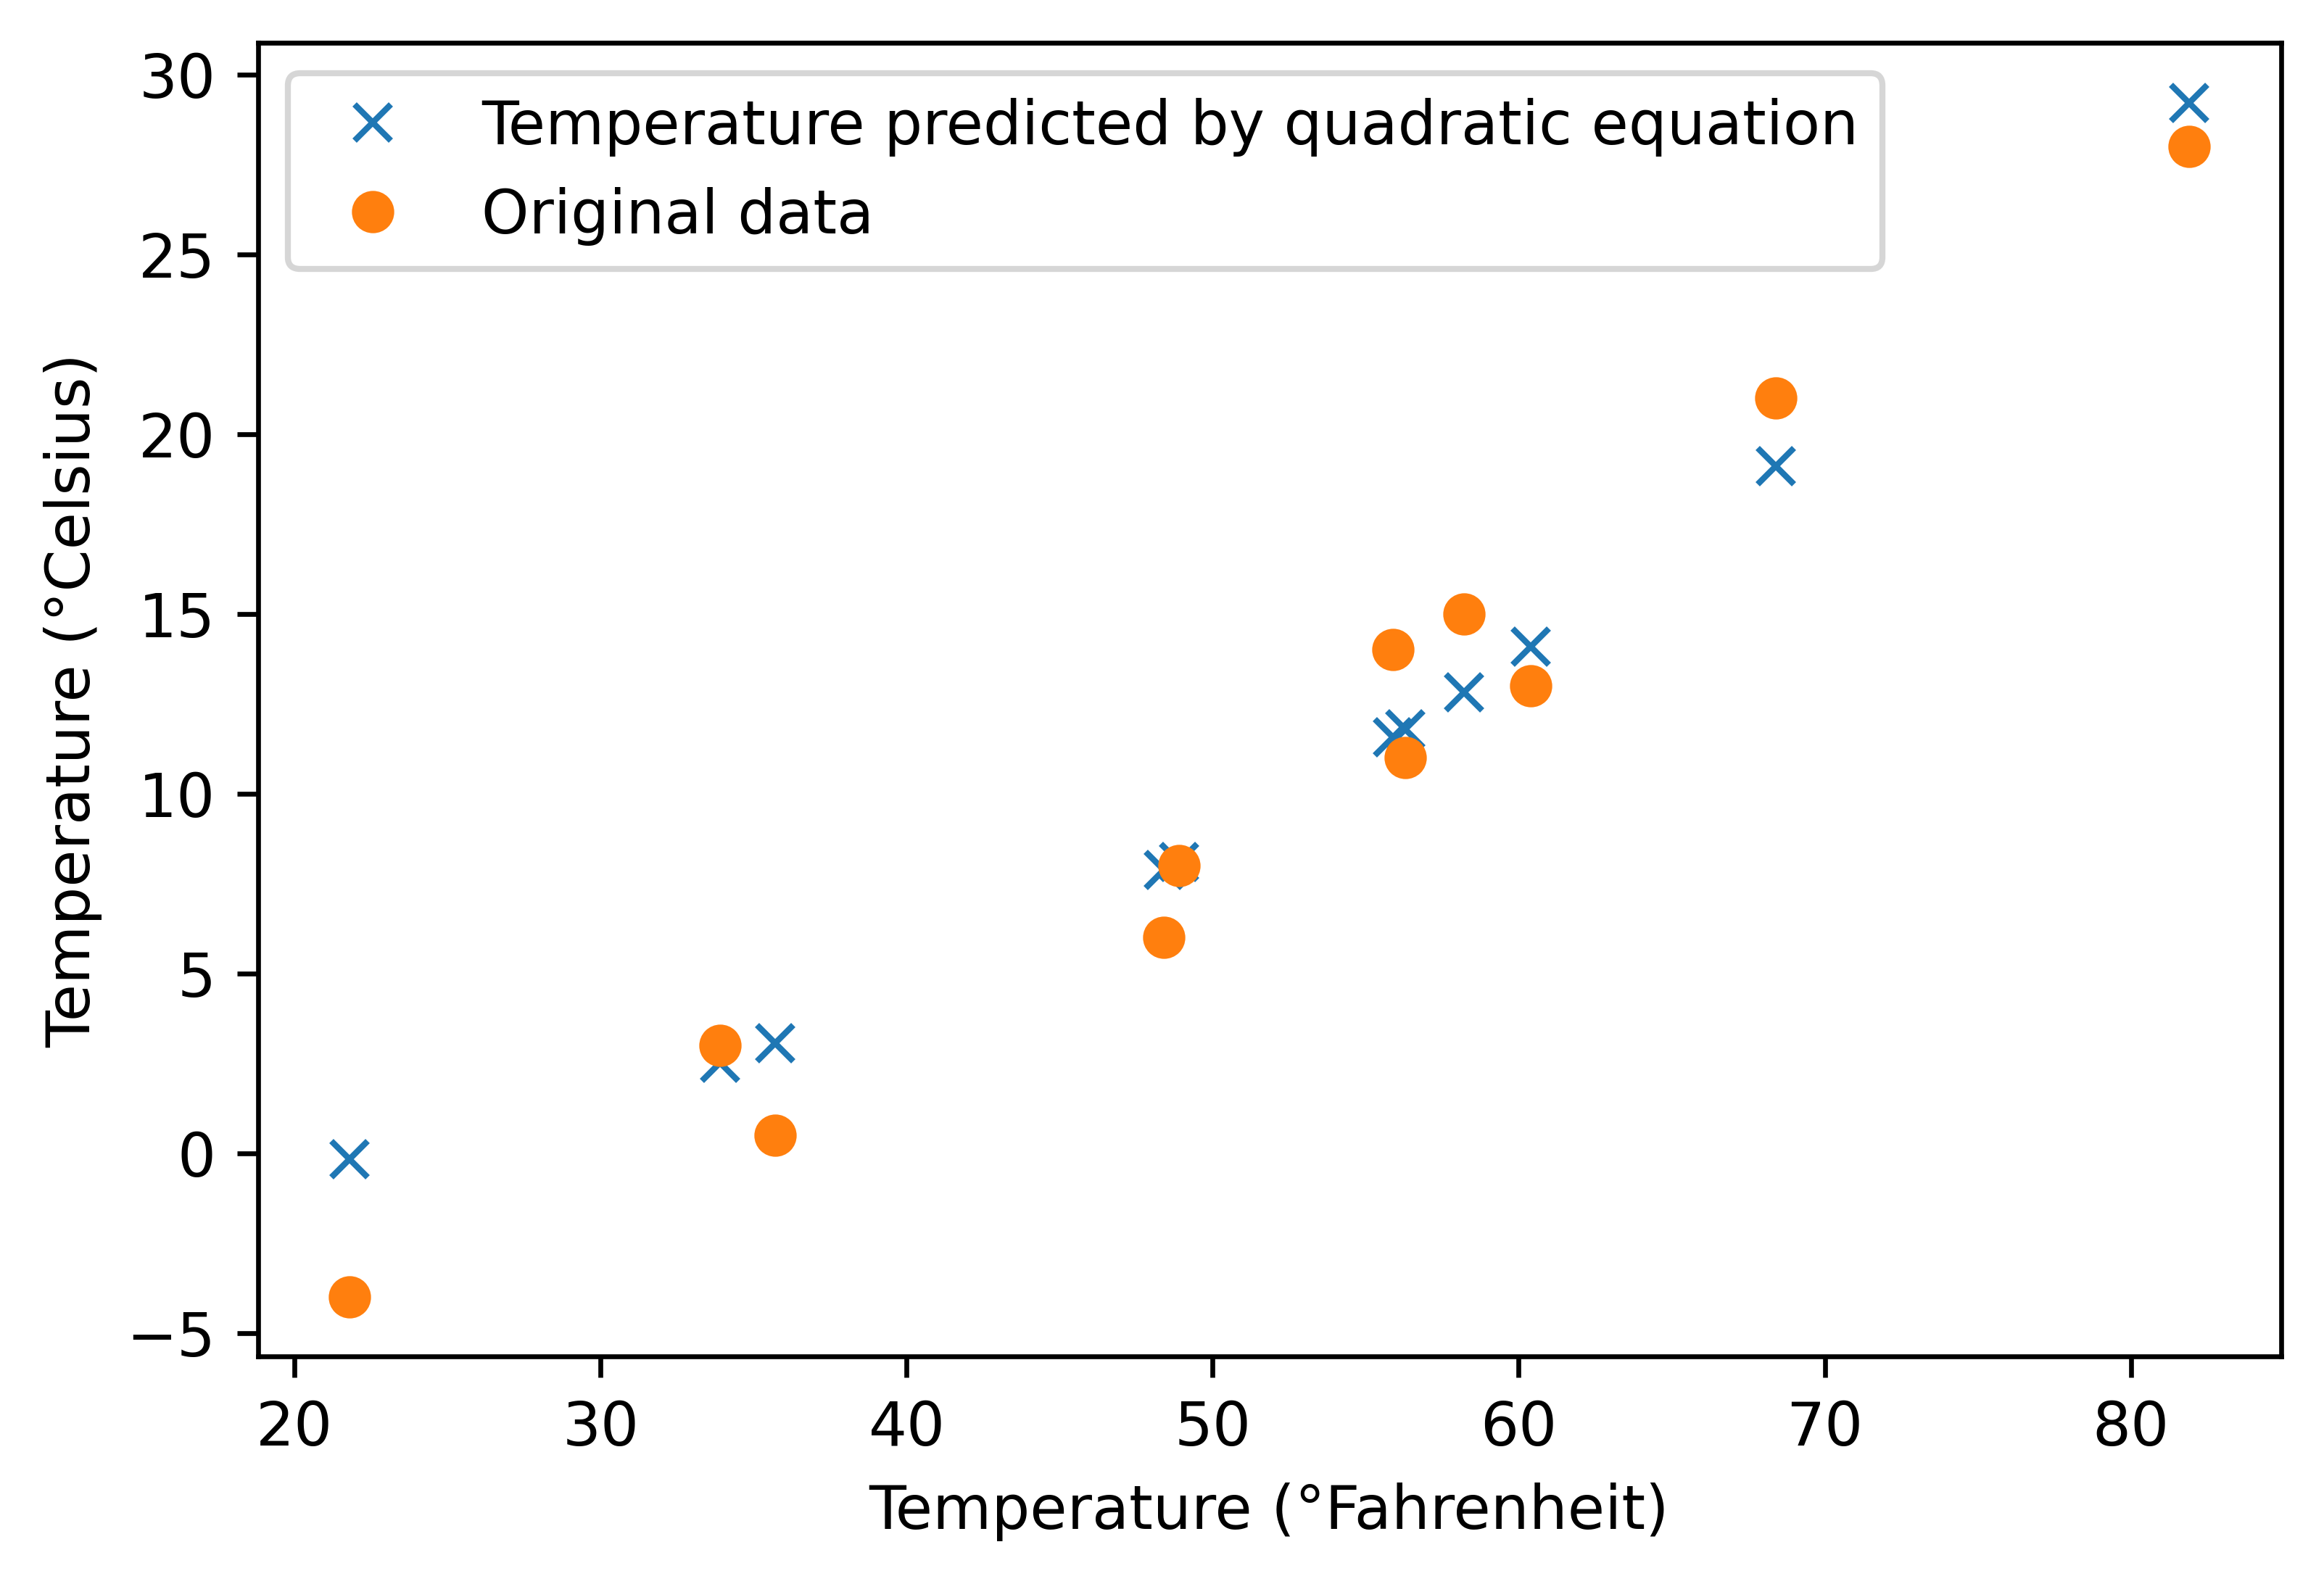

In [19]:
# 畫圖 視覺化資料
from matplotlib import pyplot as plt 
t_p = model(t_un, *params) # 預測成果 
fig = plt.figure(dpi=600) 
plt.xlabel("Temperature (°Fahrenheit)") 
plt.ylabel("Temperature (°Celsius)")
plt.plot(t_u.numpy(), t_p.numpy(), 'x', label ="Temperature predicted by quadratic equation") # 訓練結果
plt.plot(t_u.numpy(), t_c.numpy(), 'o', label ="Original data") # 原始
plt.legend()